In [1]:
from __future__ import annotations

import os
import sys

import numpy as np


sys.path.append("..")
from sun_topicmodel.snmf import SNMF
from sun_topicmodel.suntopic import suntopic

In [2]:
from sun_topicmodel import suntopic

In [5]:
np.random.seed(44)
data_test = np.random.randn(5, 5)
data_test

array([[-0.75061472,  1.31635732,  1.24614003, -1.60491574, -1.46814368],
       [-1.71507046,  1.85878369,  0.08758798, -0.0523222 ,  0.55547164],
       [-0.96340369, -0.18032147, -1.18340916,  0.60544592, -0.95165055],
       [ 0.36085606,  1.06061026, -0.11715218,  0.82566485, -1.20981355],
       [-1.19050362,  0.21987182, -0.21291913, -1.41149914, -0.48298102]])

In [11]:
np.random.seed(44)
# Create a random number generator
rng = np.random.default_rng()

# Generate random data using the new Generator API
data_test = rng.standard_normal((5, 5))
data_test

array([[-1.29975333,  0.50167663, -1.19105232,  1.76818797,  0.13983246],
       [ 0.46701944, -0.0335775 , -1.09230043, -0.91489119,  0.89138841],
       [ 0.49050491, -0.25908467,  1.16170714,  0.49306137,  0.90221951],
       [ 1.55473236,  0.6820309 ,  0.73038494, -1.0329986 , -1.39933515],
       [-0.71953141, -2.0988653 ,  0.20098768, -0.60792622,  0.66051587]])

In [26]:
# Create a random number generator
rng = np.random.default_rng(seed=42)

data_test = rng.standard_normal((5, 5))
data_test

array([[ 0.30471708, -1.03998411,  0.7504512 ,  0.94056472, -1.95103519],
       [-1.30217951,  0.1278404 , -0.31624259, -0.01680116, -0.85304393],
       [ 0.87939797,  0.77779194,  0.0660307 ,  1.12724121,  0.46750934],
       [-0.85929246,  0.36875078, -0.9588826 ,  0.8784503 , -0.04992591],
       [-0.18486236, -0.68092954,  1.22254134, -0.15452948, -0.42832782]])

In [27]:
model_test = SNMF(data_test, num_bases=3, random_state=44)
model_test.W

array([[1.2, 0.2, 0.2],
       [0.2, 1.2, 0.2],
       [0.2, 0.2, 1.2],
       [0.2, 1.2, 0.2],
       [1.2, 0.2, 0.2]])

In [29]:
model_test = SNMF(data_test, num_bases=3, random_state=44)
model_test.factorize(niter=10)
model_test.H

array([[ 0.15267809, -0.90650513,  0.93239813,  0.18052979, -1.23454713],
       [-1.24915809,  0.16639575, -0.73022645, -0.00441065, -0.35860456],
       [ 1.04916613,  0.75847681, -0.11758287,  1.14149388,  0.72544398]])

In [3]:
sample_X = np.random.rand(100, 10)
sample_Y = np.random.rand(100, 1)

model = suntopic(sample_Y, sample_X, alpha=0.5, num_bases=4)

model.summary()

Suntopic Model Summary
Number of topics:  4
Alpha:  0.5
Data shape:  (100, 11)
Model:  <sun_topicmodel.snmf.SNMF object at 0x17d054b50>
Number of iterations of model fit:  0
Random initialization state:  None
Frobenius norm error:  13.504586573341284
Prediction coefficients:  [0. 0. 0. 0.]
In-sample MSE:  0.3161750103246227


In [5]:
from joblib import Parallel, delayed
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error


In [6]:
def gen_data(dim = 10, 
             linear_combinations = False,
             n_samples= 100, 
             n_centroids=10, 
             noise_scale=0.3, 
             independent_covs=True, 
             random_state=0, 
             var_scale=0.1):

    """ 
    Function to generate multivariate normal data in dim dimensions with n_classes centroids
    Inputs:
        dim: dimensionality of data
        linear_combinations: whether to generate data as linear combinations of centroids or not
        n_samples: number of samples to generate
        n_classes: number of classes to generate
        n_centroids: number of centroids to generate
        noise_scale: scale of noise to add to data
        independent_covs: whether to generate covariance matrices for each cluster as identity matrices or not 
        random_state: random seed
        var_scale: scale of variance of covariance matrices
    Outputs:
        X: data matrix
        Y: response vector
        effects: true effects of each cluster
    """

    if linear_combinations != False:
        assert n_samples % n_centroids == 0, "n_samples must be a multiple of linear_combinations"

    np.random.seed(random_state)    

    # 1. Generate centroids
    centroids = np.array([np.random.uniform(low=-10, high=10, size=dim) for i in range(n_centroids)]) 

    # 2. Generate covariance matrices
    covs = [] 

    if independent_covs == False:
        for i in range(n_centroids): 
            A = np.random.rand(dim, dim)
            covs.append(np.dot(A, A.T)*var_scale)

    if independent_covs == True:
        for i in range(n_centroids): 
            a = var_scale
            covs.append(np.identity(dim)*a)

    # 3. Generate data points around centroids
    X = np.concatenate([np.random.multivariate_normal(mean=centroids[i], 
                                                      cov= covs[i],
                                                      size=int(n_samples/n_centroids)) 
                                                      for i in range(n_centroids)], 
                                                      axis=0)
    
    if linear_combinations == True:
        n = int(n_samples/n_centroids)
        M = np.identity(n_samples)
        for i in range(n_samples):
            M[i,  np.mod(i+n, n_samples)] = 1


        X = np.dot(M, X)
        # X is of dimensions : n_samples x dim 
        # lineae_combinations is of dimensions : n_samples_samples 

    # 4. Generate response variable
    # pick a random subset of centroids 
    subset = np.sort(np.random.choice(n_centroids, size=int(np.ceil(n_centroids/3)), replace=False))
    effects = np.zeros(n_centroids)
    for s in subset:   
      effects[s] = np.random.normal(loc=0, scale=2)

    Y = np.repeat(effects, n_samples/n_centroids)

    # combine effects associated with linear combinations of centroids
    if linear_combinations == True:
        Y= np.dot(M, Y)       

    noise = np.random.normal(loc=0, scale=noise_scale, size=n_samples)  
    Y = Y + noise

    return X, Y, effects
    
    # main choice variables: 
dim = 100
n_samples = 1000
cv_folds = 5    
topic_range = range(2, 11)
alpha_range = np.linspace(0.1,1,10)
alpha_steps = 10
var_scale = 1
random_state = 0
noise_scale = 0.5
independent_covs = False



X, Y, effects = gen_data(dim = dim,
                         n_samples= 1000, 
                         n_centroids=10, 
                         noise_scale=noise_scale,
                         independent_covs=independent_covs, 
                         random_state=random_state,
                         var_scale=var_scale)

In [4]:
cv_folds = 2
random_state = 21
niter = 10
kf = KFold(n_splits=cv_folds, random_state=random_state, shuffle=True)
alpha_range = np.linspace(0.1, 0.9, 9)
num_bases_range = [2,3,4,5,6,8,9]

In [5]:
model = suntopic(Y, X , alpha = 0.5, num_bases = 3, random_state = 0)
model.fit(niter = 10, verbose = True)


2024-04-10 11:18:23,214 [INFO] SNMF - Initial Assignment: [0 2 1 0 1 0 2 1 2 0 1 0 1 0 2 2 0 1 1 1 1 2 2 0 0 0 1 1 0 0 2 0 2 2 0 1 2
 1 1 0 1 2 2 1 2 2 1 1 2 2 1 0 0 1 1 2 2 0 1 1 2 0 2 2 1 2 2 2 2 0 2 1 0 2
 2 2 1 1 1 1 1 2 0 1 1 1 2 2 2 2 1 1 2 2 0 1 0 2 0 1 0 1 2 0 1 2 2 0 1 2 2
 1 2 2 1 0 2 0 1 2 0 2 1 2 2 1 1 2 1 1 0 2 2 2 2 2 0 2 2 2 0 2 0 2 2 2 2 0
 0 1 2 1 1 1 2 0 2 0 0 0 1 0 2 0 1 2 1 0 2 1 1 2 0 2 0 2 0 2 2 1 0 2 0 0 0
 2 1 2 0 1 0 1 2 0 0 1 2 2 2 2 1 0 0 1 2 1 0 0 2 0 1 2 0 2 2 2 2 1 2 2 2 0
 0 2 0 2 1 1 0 2 2 2 0 1 2 1 2 2 2 2 2 1 0 2 0 0 1 2 0 0 1 0 0 2 1 2 0 0 2
 2 2 2 0 1 2 2 0 2 2 0 1 2 1 1 0 1 2 2 2 2 2 2 1 1 2 0 2 0 1 2 2 0 2 2 2 0
 1 2 2 2 0 1 0 2 1 2 1 2 2 2 1 2 2 2 2 1 2 2 2 2 2 1 1 1 0 2 1 1 1 0 1 0 1
 1 0 1 1 0 1 1 2 2 1 1 2 1 1 2 2 0 0 1 2 1 0 0 1 1 2 2 2 2 1 0 2 0 2 1 0 2
 0 1 1 1 1 1 1 1 2 1 2 2 1 1 0 2 0 1 1 2 2 1 1 0 2 1 1 2 2 1 2 2 2 2 2 0 0
 2 2 2 2 2 0 0 0 2 1 0 0 2 0 2 2 1 2 0 2 1 0 0 0 2 1 2 2 0 2 1 0 2 2 0 1 2
 1 0 2 0 1 1 0 0 2 1 2 0 1 2 0 0 2 2 2 0 2

In [7]:
np.random.seed(44)
data_test = np.random.randn(5, 5)
W_init = np.array(
    [
        [0.2, 0.2, 1.2],
        [1.2, 0.2, 0.2],
        [0.2, 1.2, 0.2],
        [0.2, 1.2, 0.2],
        [1.2, 0.2, 0.2],
    ]
)

In [13]:
model = suntopic(sample_Y, sample_X, alpha=0.5, num_bases=4)

model.summary()

Suntopic Model Summary
Number of topics:  4
Alpha:  0.5
Data shape:  (100, 11)
Model:  <sun_topicmodel.snmf.SNMF object at 0x16b90d250>
Random initialization state:  None
Prediction coefficients:  [0. 0. 0. 0.]
In-sample MSE:  0.3696334081507273


In [12]:
model_test.H

array([[-0.32669956,  0.74387423,  0.93648991, -1.33034828, -0.8511209 ],
       [ 0.27245913,  0.05884138, -0.69700324,  1.14860852, -0.84084191],
       [-1.81000638,  1.04106534, -0.24569931, -0.37936771,  0.78046609]])

In [11]:
model_test = SNMF(data_test, num_bases=3, random_state=44)
model_test.W
model_test.factorize(niter=100)
model_test.W

array([[1.52470373, 0.35551883, 0.16962139],
       [0.27186667, 0.36576728, 1.10171944],
       [0.06190612, 1.05355333, 0.4329433 ],
       [0.56136486, 1.21188858, 0.06083884],
       [0.56510076, 0.01579591, 0.3990419 ]])

In [8]:
model.cv_summary(top_hyperparam_combinations = 5)

Cross-Validation Summary
Alpha candidate values:  [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
Number of topics:  [2, 3, 4, 5, 6, 8, 9]
Number of folds:  5
CV Random state:  0
Top 1 hyperparam combinations - num_bases: 9, alpha: 0.1, MSE: 0.3022
Top 2 hyperparam combinations - num_bases: 9, alpha: 0.30000000000000004, MSE: 0.3323
Top 3 hyperparam combinations - num_bases: 9, alpha: 0.4, MSE: 0.3325
Top 4 hyperparam combinations - num_bases: 9, alpha: 0.5, MSE: 0.3326
Top 5 hyperparam combinations - num_bases: 9, alpha: 0.6, MSE: 0.3327


In [7]:
model.hyperparam_cv(alpha_range = alpha_range, num_bases_range = num_bases_range, cv_folds= 5,
    random_state = 0, niter = 100, verbose = True, parallel = True)

In [9]:
model._logger

<Logger suntopic (INFO)>

In [10]:
model.cv_summary(top_hyperparam_combinations = 5)

Cross-Validation Summary
Alpha candidate values:  [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
Number of topics:  [2, 3, 4, 5, 6, 8, 9]
Number of folds:  5
CV Random state:  0
Top 1 hyperparam combinations - num_bases: 9, alpha: 0.1, MSE: 0.3022
Top 2 hyperparam combinations - num_bases: 9, alpha: 0.30000000000000004, MSE: 0.3323
Top 3 hyperparam combinations - num_bases: 9, alpha: 0.4, MSE: 0.3325
Top 4 hyperparam combinations - num_bases: 9, alpha: 0.5, MSE: 0.3326
Top 5 hyperparam combinations - num_bases: 9, alpha: 0.6, MSE: 0.3327


In [11]:
np.mean(model.cv_errors, axis =2)

array([[0.65512227, 0.65596157, 0.65623766, 0.65637502, 0.65645722,
        0.65651193, 0.65655097, 0.65658022, 0.65660295],
       [0.56906691, 0.57054646, 0.5711199 , 0.57136354, 0.57150949,
        0.57160089, 0.57167025, 0.57172224, 0.57176266],
       [0.55386611, 0.5553823 , 0.55589135, 0.55614511, 0.55517405,
        0.55527822, 0.55535258, 0.55540831, 0.55545165],
       [0.52583555, 0.52351178, 0.52401746, 0.52426962, 0.5227167 ,
        0.52281694, 0.5228885 , 0.52294214, 0.52298385],
       [0.50615384, 0.50805879, 0.50869151, 0.50900743, 0.50451617,
        0.50465197, 0.50474895, 0.50482167, 0.50487821],
       [0.36103528, 0.35885842, 0.35972221, 0.36028482, 0.36062505,
        0.36085298, 0.36101633, 0.36113914, 0.36123483],
       [0.3021595 , 0.33281185, 0.33234432, 0.33252022, 0.33262743,
        0.33269961, 0.33275152, 0.33279063, 0.33282117]])

In [12]:
model.cv_errors

array([[[0.67503431, 0.66449576, 0.7184715 , 0.71111822, 0.50649158],
        [0.67594566, 0.66575995, 0.71923825, 0.71232029, 0.50654369],
        [0.67624495, 0.66617656, 0.7194899 , 0.71271614, 0.50656075],
        [0.67639376, 0.66638397, 0.719615  , 0.71291316, 0.50656923],
        [0.67648277, 0.66650814, 0.71968983, 0.71303108, 0.5065743 ],
        [0.67654201, 0.66659079, 0.71973962, 0.71310958, 0.50657767],
        [0.67658426, 0.66664977, 0.71977513, 0.71316559, 0.50658007],
        [0.67661593, 0.66669398, 0.71980174, 0.71320757, 0.50658188],
        [0.67664054, 0.66672834, 0.71982242, 0.7132402 , 0.50658328]],

       [[0.5747101 , 0.59667672, 0.62299601, 0.60033748, 0.45061424],
        [0.5760934 , 0.59827826, 0.62487404, 0.60234961, 0.451137  ],
        [0.57655156, 0.59923047, 0.62549223, 0.60301598, 0.45130926],
        [0.57678009, 0.59949437, 0.62579984, 0.60334837, 0.45139505],
        [0.57691703, 0.59965252, 0.62598395, 0.60354753, 0.45144641],
        [0.5770082

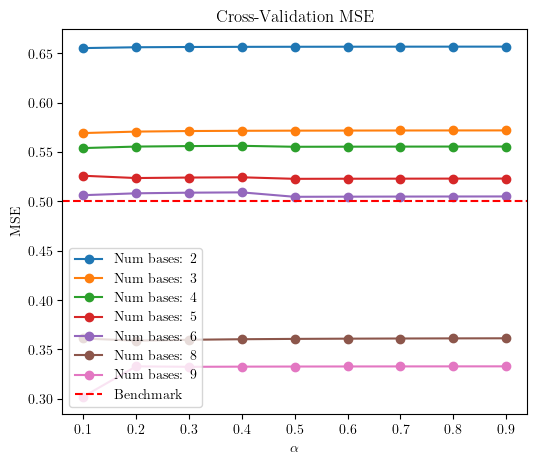

In [14]:
model.cv_mse_plot(benchmark = 0.5, figsize = (6, 5))

In [3]:
np.random.seed(44)
# Generate a random matrix X 
X = np.random.randn(3, 50)
snmf_test = SNMF(X, num_bases=2, random_state=44, legacy_mode=True)
snmf_test.factorize(niter=2, show_progress=True)

2024-04-03 12:13:44,045 [INFO] SNMF - Initial Assignment: [0 1 1]
2024-04-03 12:13:44,046 [INFO] FN: 6.977439325329257 (1 / 2)
2024-04-03 12:13:44,047 [INFO] FN: 6.929638965422419 (2 / 2)


In [4]:
snmf_test = SNMF(X, num_bases=2, random_state=44, legacy_mode=True)
snmf_test.factorize(niter=2, show_progress=True)

2024-04-03 12:13:53,887 [INFO] SNMF - Initial Assignment: [0 1 1]
2024-04-03 12:13:53,887 [INFO] FN: 6.977439325329257 (1 / 2)
2024-04-03 12:13:53,888 [INFO] FN: 6.929638965422419 (2 / 2)


In [5]:
np.random.seed(44)
# Generate a random matrix X 
X = np.random.randn(3, 50)
snmf_test = SNMF(X, num_bases=2, random_state=44, legacy_mode=True)
snmf_test.factorize(niter=20, show_progress=False)
H_test = snmf_test.H
W_test = snmf_test.W

print(X)
print(W_test.shape)
print(W_test)
print(H_test)

[[-7.50614717e-01  1.31635732e+00  1.24614003e+00 -1.60491574e+00
  -1.46814368e+00 -1.71507046e+00  1.85878369e+00  8.75879763e-02
  -5.23221964e-02  5.55471637e-01 -9.63403694e-01 -1.80321465e-01
  -1.18340916e+00  6.05445921e-01 -9.51650553e-01  3.60856060e-01
   1.06061026e+00 -1.17152178e-01  8.25664851e-01 -1.20981355e+00
  -1.19050362e+00  2.19871821e-01 -2.12919130e-01 -1.41149914e+00
  -4.82981016e-01  1.20176208e+00 -7.05803033e-01  2.51813547e-02
  -3.91128155e-01  1.93139124e-01  3.49290932e-01  5.91188382e-01
   5.20409870e-01  8.25222389e-01  4.26203507e-01  1.95640026e-01
  -5.14112178e-01 -3.07368882e+00 -3.95159070e-01 -7.95399184e-01
  -7.03201512e-01 -1.73739268e+00  7.50808258e-01 -1.86395314e+00
   4.18510984e-01 -2.35333837e-01  4.32107174e-01  8.70291930e-01
   2.00862219e+00  1.37177091e+00]
 [ 1.05859789e+00  1.44533756e+00  4.88232904e-02  9.03295203e-02
  -4.80256813e-01  3.00662736e-01  1.11297983e+00 -1.93150462e-02
  -8.07598399e-04 -6.38530234e-01  1.5946

In [6]:
print(W_test.shape)
print(W_test)
print(H_test)

(3, 2)
[[1.17797732 0.2087255 ]
 [0.34645526 0.84559617]
 [0.14539624 1.46598459]]
[[-0.80267244  1.36060009  0.90024422 -1.28755122 -1.41040407 -1.40454204
   1.75164169 -0.07776795  0.40059172  0.47474941 -0.65515775 -0.20559119
  -0.83270751  0.83826749 -0.8058675   0.3466136   0.80567418 -0.21366554
   0.83469297 -1.20397126 -1.22763569  0.30613543  0.05494692 -1.36912669
  -0.86629273  1.31277382 -0.73805959  0.13504014 -0.30046357 -0.48583546
   0.26397705  0.41342366  0.53045239  0.92354565  0.11736057 -0.23933129
  -0.69279653 -2.37885053 -0.22428498 -0.81647817 -0.74429769 -1.32292411
   0.55264664 -1.68885933  0.34056615 -0.16078402  0.42005637  0.7640741
   1.8728926   1.17709454]
 [ 1.24297945 -0.16167407  0.31355534  0.08413558  0.48627001  0.29518286
  -0.2229733   0.45078035 -1.3851298  -0.4643786   0.55468435  0.20502201
  -0.02297159 -1.22876441  0.41476171 -1.21695439  0.19508302  0.02750018
   0.18477192  1.19522359  0.71909032 -0.82094456 -1.23700905  1.08852179
   

In [14]:
np.random.seed(44)
# Generate a random matrix X 
X = np.random.randn(3, 50)
snmf_test = SNMF(X, num_bases=2, random_state=44, legacy_mode=True)
snmf_test.factorize(niter=20, show_progress=False)
H_test = snmf_test.H
W_test = snmf_test.W

print(X)
print(W_test.shape)
print(W_test)
print(H_test)

Assign: [0 1 1]
H1: [[1.52 0.72]
 [0.72 2.92]] 
 H2: [[-3.79172008e-01  1.73962094e+00  1.68100032e+00 -1.97150936e+00
  -1.71235220e+00 -2.01106834e+00  2.36292594e+00  2.71948624e-01
  -5.70084607e-01  4.61363216e-01 -8.41362757e-01 -1.49418736e-01
  -1.43377236e+00  2.90903440e-01 -9.94002210e-01 -1.78080266e-01
   1.41398420e+00 -2.00301398e-01  1.23668978e+00 -1.00117009e+00
  -1.25901261e+00 -9.78832212e-02 -8.14390340e-01 -1.31483406e+00
  -2.69953001e-01  1.62585272e+00 -1.00859940e+00 -3.04023254e-01
  -8.15065329e-01  5.20160442e-01  5.74447002e-01  5.55301253e-01
   8.77528374e-01  7.39712344e-01  2.00454578e-01  4.28140366e-01
  -3.38505490e-01 -3.54784737e+00 -7.63029738e-01 -8.91433477e-01
  -1.15171695e+00 -1.86850089e+00  2.93910448e-01 -2.03317426e+00
   4.98841178e-01 -2.38177531e-01  6.39755345e-01  1.32674228e+00
   2.20639116e+00  1.07948270e+00]
 [ 2.97927097e+00  1.22322436e+00  1.36302175e+00 -5.94645968e-01
   2.89257694e-03 -6.09168210e-02  1.16606978e+00  1.0

In [16]:

print(W_test.shape)
print(W_test)
print(H_test)

(3, 2)
[[1.17797732 0.2087255 ]
 [0.34645526 0.84559617]
 [0.14539624 1.46598459]]
[[-0.80267244  1.36060009  0.90024422 -1.28755122 -1.41040407 -1.40454204
   1.75164169 -0.07776795  0.40059172  0.47474941 -0.65515775 -0.20559119
  -0.83270751  0.83826749 -0.8058675   0.3466136   0.80567418 -0.21366554
   0.83469297 -1.20397126 -1.22763569  0.30613543  0.05494692 -1.36912669
  -0.86629273  1.31277382 -0.73805959  0.13504014 -0.30046357 -0.48583546
   0.26397705  0.41342366  0.53045239  0.92354565  0.11736057 -0.23933129
  -0.69279653 -2.37885053 -0.22428498 -0.81647817 -0.74429769 -1.32292411
   0.55264664 -1.68885933  0.34056615 -0.16078402  0.42005637  0.7640741
   1.8728926   1.17709454]
 [ 1.24297945 -0.16167407  0.31355534  0.08413558  0.48627001  0.29518286
  -0.2229733   0.45078035 -1.3851298  -0.4643786   0.55468435  0.20502201
  -0.02297159 -1.22876441  0.41476171 -1.21695439  0.19508302  0.02750018
   0.18477192  1.19522359  0.71909032 -0.82094456 -1.23700905  1.08852179
   

In [10]:
np.random.seed(44)
# Generate a random matrix X 
X = np.random.randn(3, 5)
snmf_test = SNMF(X, num_bases=2, random_state=44, legacy_mode=False)
snmf_test.factorize(niter=1, show_progress=False)
H_test = snmf_test.H
W_test = snmf_test.W

print(X)
print(W_test.shape)
print(W_test)
print(H_test)

Assign: [0 1 1]
H1: [[1.52 0.72]
 [0.72 2.92]] 
 H2: [[-1.43643249  1.91532123  1.2762038  -1.81527414 -1.8410082 ]
 [-3.36429193  2.27742614 -1.06575741  0.34276532 -0.76904344]] 

W1: [[7.26156694 0.5343712 ]
 [2.67528366 2.80252752]
 [0.5343712  2.00662743]] 
 W2: [[7.26156694 0.53437121]
 [1.21026116 2.40457748]
 [1.99939371 2.40457748]]
[[-0.75061472  1.31635732  1.24614003 -1.60491574 -1.46814368]
 [-1.71507046  1.85878369  0.08758798 -0.0523222   0.55547164]
 [-0.96340369 -0.18032147 -1.18340916  0.60544592 -0.95165055]]
(3, 2)
[[1.2        0.2       ]
 [0.29735508 1.29549816]
 [0.10339567 1.09621371]]
[[-0.45206446  1.00841612  1.14639297 -1.4151509  -1.23011037]
 [-1.04068682  0.53128991 -0.64765765  0.4663267   0.03994385]]
